# Cohort Analysis

In [ ]:
import os

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from matplotlib import gridspec
from matplotlib.lines import Line2D

from src.config import conf

if any("Arial" in f.name for f in fm.fontManager.ttflist):
    plt.rcParams["font.family"] = "Arial"

Consider drugs with a PROTON-predicted rank $< 60$ that are FDA approved for a non-dementia indication associated with specific ICD-10 diagnosis codes in the personal health data.

In [ ]:
# Make output directory
os.makedirs(conf.paths.notebooks.cohort_analysis_dir, exist_ok=True)

# Read results of ADRD analysis
ad_df = pd.read_excel(conf.paths.notebooks.private_ehr_dir / "combined_result_AD.xlsx", sheet_name="filtered_result")
ad_df = ad_df[ad_df["IndicationRank"] < 60]
ad_plot = ad_df.sort_values("MED_exp").reset_index(drop=True)

# Drop ADRD drugs
ad_plot = ad_plot[ad_plot["Drug Name"] != "Levodopa"].reset_index(drop=True)

## Plot Forest Plot

In [ ]:
# Extra columns for the stacked bars
ad_plot["Control_No_ADRD"] = ad_plot["Total Control"] - ad_plot["Control ADRD"]
ad_plot["Treatment_No_ADRD"] = ad_plot["Total Treatment"] - ad_plot["Treatment ADRD"]

no_sig_color = "lightgrey"
sig_color = "#ff7f0e"
high_sig_color = "#d62728"


# Color for each point, based on p-value
def pcolor(p):
    if p > 0.05:
        return no_sig_color
    if p <= 0.001:
        return high_sig_color
    return sig_color


def psize(p):
    if p > 0.05:
        return 6
    if p <= 0.001:
        return 10
    return 8


point_colors = ad_plot["MED_p_value"].apply(pcolor)
point_size = ad_plot["MED_p_value"].apply(psize)

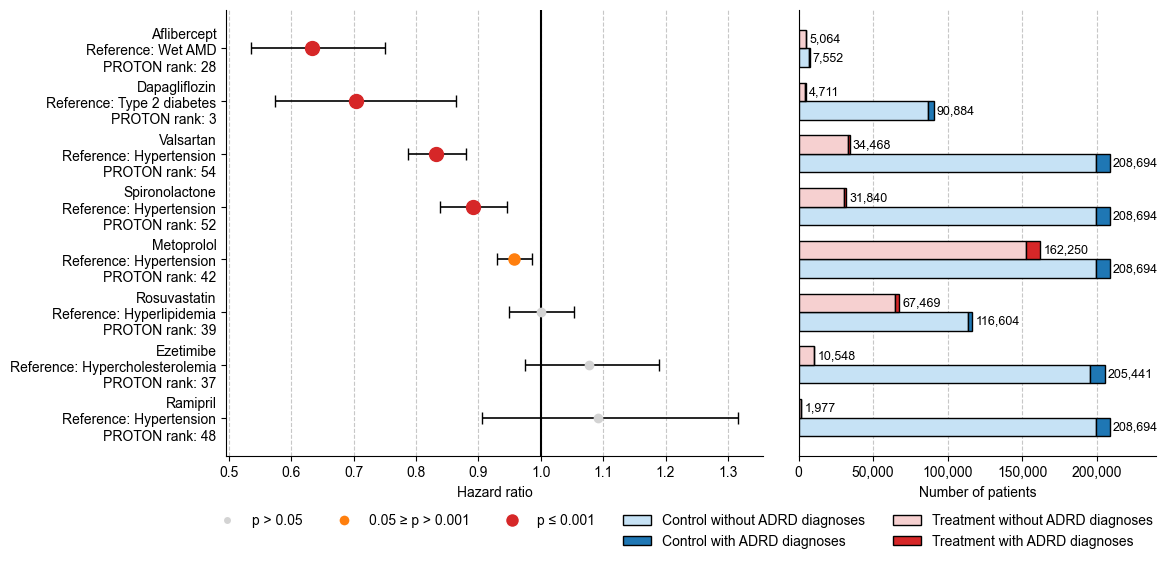

In [ ]:
fig = plt.figure(figsize=(12, 0.6 * len(ad_plot) + 1))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2], wspace=0.08)

ax_fp = fig.add_subplot(gs[0])
xerr = np.stack([ad_plot["MED_exp"] - ad_plot["MED_hr_lower"], ad_plot["MED_hr_upper"] - ad_plot["MED_exp"]])

ax_fp.errorbar(
    x=ad_plot["MED_exp"],
    y=ad_plot.index,
    xerr=xerr,
    fmt="o",
    mec="none",
    mfc="none",
    ecolor="black",
    capsize=4,
    lw=1.2,
    zorder=2,
)
for y, x, c, size in zip(ad_plot.index, ad_plot["MED_exp"], point_colors, point_size, strict=False):
    ax_fp.plot(x, y, "o", ms=size, color=c, zorder=5)

ax_fp.axvline(1, color="black", lw=1.5, zorder=3)
ax_fp.set_xlabel("Hazard ratio")

y_pos = np.arange(len(ad_plot))
ax_fp.set_yticks(y_pos)
y_labels = []
for _i, row in ad_plot.iterrows():
    drug_name = row["Drug Name"]
    indication = row["Indication"]
    if indication == "DM2":
        indication = "Type 2 diabetes"
    if indication == "wet AMD":
        indication = "Wet AMD"
    rank = row["IndicationRank"]
    y_labels.append(f"{drug_name}\nReference: {indication}\nPROTON rank: {rank}")

ax_fp.set_yticklabels(y_labels, fontsize=10)
ax_fp.invert_yaxis()

ax_fp.grid(True, axis="x", ls="--", alpha=0.7)
ax_fp.spines["right"].set_visible(False)
ax_fp.spines["top"].set_visible(False)

ax_fp.legend(
    handles=[
        Line2D([0], [0], marker="o", color="w", mfc=no_sig_color, label="p > 0.05", markersize=6),
        Line2D([0], [0], marker="o", color="w", mfc=sig_color, label="0.05 ≥ p > 0.001", markersize=8),
        Line2D([0], [0], marker="o", color="w", mfc=high_sig_color, label="p ≤ 0.001", markersize=10),
    ],
    loc="upper right",
    frameon=False,
    bbox_to_anchor=(0.71, -0.1),
    ncol=3,
)

ax_bar = fig.add_subplot(gs[1], sharey=ax_fp)

y = ad_plot.index
h = 0.35

# Control group
ax_bar.barh(
    y + h / 2,
    ad_plot["Control_No_ADRD"],
    edgecolor="black",
    height=h,
    color="#C6E2F5",
    label="Control without ADRD diagnoses",
    zorder=3,
)
ax_bar.barh(
    y + h / 2,
    ad_plot["Control ADRD"],
    edgecolor="black",
    height=h,
    left=ad_plot["Control_No_ADRD"],
    color="#1F77B4",
    label="Control with ADRD diagnoses",
    zorder=3,
)

# Treatment group
ax_bar.barh(
    y - h / 2,
    ad_plot["Treatment_No_ADRD"],
    edgecolor="black",
    height=h,
    color="#F6D0D0",
    label="Treatment without ADRD diagnoses",
    zorder=3,
)
ax_bar.barh(
    y - h / 2,
    ad_plot["Treatment ADRD"],
    edgecolor="black",
    height=h,
    left=ad_plot["Treatment_No_ADRD"],
    color="#D62728",
    label="Treatment with ADRD diagnoses",
    zorder=3,
)

# Add total patient counts to the right of the bars
for idx, row in ad_plot.iterrows():
    ctrl_total = row["Control_No_ADRD"] + row["Control ADRD"]
    treat_total = row["Treatment_No_ADRD"] + row["Treatment ADRD"]

    # Position annotations just beyond the total bar length
    ax_bar.text(ctrl_total + 2000, idx + h / 2, f"{ctrl_total:,}", va="center", ha="left", fontsize=9)
    ax_bar.text(treat_total + 2000, idx - h / 2, f"{treat_total:,}", va="center", ha="left", fontsize=9)

# Compute max total patient count across all rows
max_total = (
    (ad_plot["Control_No_ADRD"] + ad_plot["Control ADRD"])
    .combine(ad_plot["Treatment_No_ADRD"] + ad_plot["Treatment ADRD"], func=max)
    .max()
)

# Add 5% padding to the right
ax_bar.set_xlim(0, max_total * 1.15)

ax_bar.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{x:,.0f}"))
ax_bar.set_xlabel("Number of patients")
ax_bar.tick_params(axis="y", left=False, labelleft=False)
ax_bar.grid(axis="x", ls="--", alpha=0.7, zorder=0)
ax_bar.spines["right"].set_visible(False)
ax_bar.spines["top"].set_visible(False)

ax_bar.legend(ncol=2, frameon=False, fontsize=10, loc="upper center", bbox_to_anchor=(0.25, -0.1))  # (0.5, -0.1)

plt.savefig(conf.paths.notebooks.cohort_analysis_dir / "ADRD_forest_plot.pdf", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.cohort_analysis_dir / "ADRD_forest_plot.svg", bbox_inches="tight")
plt.show()

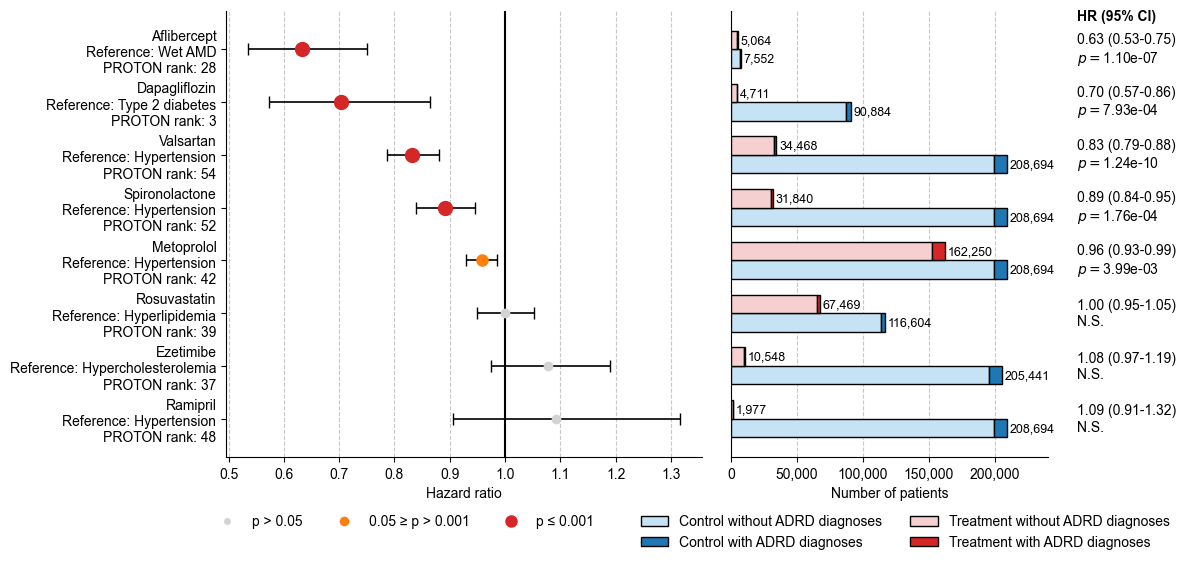

In [ ]:
fig = plt.figure(figsize=(12, 0.6 * len(ad_plot) + 1))
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 2, 0.5], wspace=0.1)

# Forest plot
ax_fp = fig.add_subplot(gs[0])

xerr = np.stack([ad_plot["MED_exp"] - ad_plot["MED_hr_lower"], ad_plot["MED_hr_upper"] - ad_plot["MED_exp"]])

ax_fp.errorbar(
    x=ad_plot["MED_exp"],
    y=ad_plot.index,
    xerr=xerr,
    fmt="o",
    mec="none",
    mfc="none",
    ecolor="black",
    capsize=4,
    lw=1.2,
    zorder=2,
)

for y, x, c, size in zip(ad_plot.index, ad_plot["MED_exp"], point_colors, point_size, strict=False):
    ax_fp.plot(x, y, "o", ms=size, color=c, zorder=5)

ax_fp.axvline(1, color="black", lw=1.5, zorder=3)
ax_fp.set_xlabel("Hazard ratio")

y_pos = np.arange(len(ad_plot))
ax_fp.set_yticks(y_pos)
y_labels = []
for _i, row in ad_plot.iterrows():
    drug_name = row["Drug Name"]
    indication = row["Indication"]
    if indication == "DM2":
        indication = "Type 2 diabetes"
    if indication == "wet AMD":
        indication = "Wet AMD"
    rank = row["IndicationRank"]
    y_labels.append(f"{drug_name}\nReference: {indication}\nPROTON rank: {rank}")

ax_fp.set_yticklabels(y_labels, fontsize=10)
ax_fp.invert_yaxis()

ax_fp.grid(True, axis="x", ls="--", alpha=0.7)
ax_fp.spines["right"].set_visible(False)
ax_fp.spines["top"].set_visible(False)

ax_fp.legend(
    handles=[
        Line2D([0], [0], marker="o", color="w", mfc=no_sig_color, label="p > 0.05", markersize=6),
        Line2D([0], [0], marker="o", color="w", mfc=sig_color, label="0.05 ≥ p > 0.001", markersize=8),
        Line2D([0], [0], marker="o", color="w", mfc=high_sig_color, label="p ≤ 0.001", markersize=10),
    ],
    loc="upper right",
    frameon=False,
    bbox_to_anchor=(0.8, -0.1),
    ncol=3,
)

# Stacked bar chart
ax_bar = fig.add_subplot(gs[1], sharey=ax_fp)

y = ad_plot.index
h = 0.35

# Control group
ax_bar.barh(
    y + h / 2,
    ad_plot["Control_No_ADRD"],
    edgecolor="black",
    height=h,
    color="#C6E2F5",
    label="Control without ADRD diagnoses",
    zorder=3,
)
ax_bar.barh(
    y + h / 2,
    ad_plot["Control ADRD"],
    edgecolor="black",
    height=h,
    left=ad_plot["Control_No_ADRD"],
    color="#1F77B4",
    label="Control with ADRD diagnoses",
    zorder=3,
)

# Treatment group
ax_bar.barh(
    y - h / 2,
    ad_plot["Treatment_No_ADRD"],
    edgecolor="black",
    height=h,
    color="#F6D0D0",
    label="Treatment without ADRD diagnoses",
    zorder=3,
)
ax_bar.barh(
    y - h / 2,
    ad_plot["Treatment ADRD"],
    edgecolor="black",
    height=h,
    left=ad_plot["Treatment_No_ADRD"],
    color="#D62728",
    label="Treatment with ADRD diagnoses",
    zorder=3,
)

# Add total patient counts annotations
for idx, row in ad_plot.iterrows():
    n_ctrl = row["Total Control"] if "Total Control" in row else row["Control_No_ADRD"] + row["Control ADRD"]
    n_treat = row["Total Treatment"] if "Total Treatment" in row else row["Treatment_No_ADRD"] + row["Treatment ADRD"]

    ax_bar.text(n_ctrl + 2000, idx + h / 2, f"{n_ctrl:,}", va="center", ha="left", fontsize=9)
    ax_bar.text(n_treat + 2000, idx - h / 2, f"{n_treat:,}", va="center", ha="left", fontsize=9)

# Bar chart scaling
max_total = (
    (ad_plot["Control_No_ADRD"] + ad_plot["Control ADRD"])
    .combine(ad_plot["Treatment_No_ADRD"] + ad_plot["Treatment ADRD"], func=max)
    .max()
)
ax_bar.set_xlim(0, max_total * 1.15)
ax_bar.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{x:,.0f}"))
ax_bar.set_xlabel("Number of patients")
ax_bar.tick_params(axis="y", left=False, labelleft=False)
ax_bar.grid(axis="x", ls="--", alpha=0.7, zorder=0)
ax_bar.spines["right"].set_visible(False)
ax_bar.spines["top"].set_visible(False)
ax_bar.legend(ncol=2, frameon=False, fontsize=10, loc="upper center", bbox_to_anchor=(0.55, -0.1))

# Statistics text table
ax_text = fig.add_subplot(gs[2], sharey=ax_fp)
ax_text.axis("off")

# Header
ax_text.text(0, -0.5, "HR (95% CI)", fontweight="bold", fontsize=10, va="bottom")

for idx, row in ad_plot.iterrows():
    # Extract values
    hr = row["MED_exp"]
    hr_low = row["MED_hr_lower"]
    hr_high = row["MED_hr_upper"]
    cox_p_val = row["MED_p_value"]

    # Format stats
    stats_str = f"{hr:.2f} ({hr_low:.2f}-{hr_high:.2f})"

    # Format p-value
    # if cox_p_val < 0.001:
    #     p_str = "$p <$0.001"
    if cox_p_val > 0.05:
        p_str = "N.S."
    else:
        # p_str = f"$p =${cox_p_val:.3f}"
        p_str = f"$p =${cox_p_val:.2e}"

    full_text = f"{stats_str}\n{p_str}"

    ax_text.text(0, idx, full_text, va="center", ha="left", fontsize=10, color="black")

plt.savefig(conf.paths.notebooks.cohort_analysis_dir / "ADRD_forest_plot_with_pval.pdf", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.cohort_analysis_dir / "ADRD_forest_plot_with_pval.svg", bbox_inches="tight")
plt.show()

## Plot Kaplan-Meier Curves

In [ ]:
km_dir = conf.paths.notebooks.private_ehr_dir / "KM_data"
aflibercept_km = pd.read_csv(km_dir / "AMD_AD_Aflibercept_KM.csv")
dapagliflozin_km = pd.read_csv(km_dir / "DM2_AD_Dapagliflozin_KM.csv", low_memory=False)
valsartan_km = pd.read_csv(km_dir / "Hypertension_AD_Valsartan_KM.csv")

KM_data = {"Aflibercept": aflibercept_km, "Dapagliflozin": dapagliflozin_km, "Valsartan": valsartan_km}

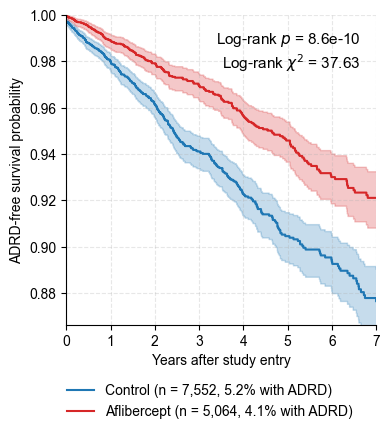

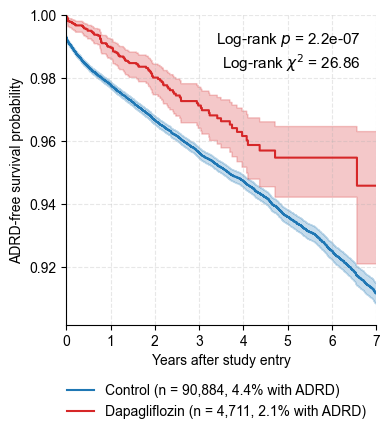

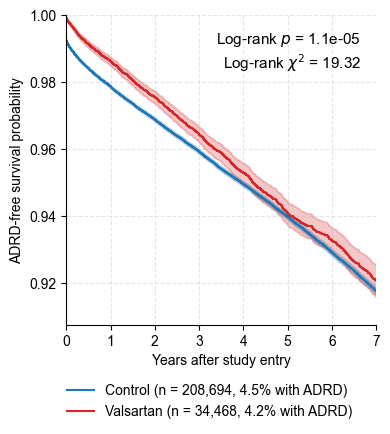

In [ ]:
for drug_name, km_df in KM_data.items():
    # Custom colors for the two arms
    colors = {
        drug_name: "#d62728",
        "Control": "#1f77b4",
    }

    kmf = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(4, 4.5))

    # Log-rank test
    treat_grp = km_df[km_df["MED"] == 1]
    ctrl_grp = km_df[km_df["MED"] == 0]

    lr_result = logrank_test(
        treat_grp["follow_up_time_days"] / 365.25,
        ctrl_grp["follow_up_time_days"] / 365.25,
        event_observed_A=treat_grp["event"],
        event_observed_B=ctrl_grp["event"],
    )
    logrank_p = lr_result.p_value
    logrank_stat = lr_result.test_statistic

    for med_val, grp in km_df.groupby("MED"):
        label = drug_name if med_val == 1 else "Control"
        kmf.fit(
            durations=grp["follow_up_time_days"] / 365.25,  # convert days to years
            event_observed=grp["event"],
            label=label,
        )
        plot = kmf.plot(ax=ax, color=colors[label])

    # Extract statistics for label
    row = ad_df.query("`Drug Name` == @drug_name").squeeze()

    hr = row["MED_exp"]
    hr_low = row["MED_hr_lower"]
    hr_high = row["MED_hr_upper"]
    cox_p_val = row["MED_p_value"]
    n_ctrl = row["Total Control"]
    n_treat = row["Total Treatment"]

    # Calculate ADRD percentages
    pct_ctrl_adrd = 100 * row["Control ADRD"] / n_ctrl
    pct_treat_adrd = 100 * row["Treatment ADRD"] / n_treat

    # Compose annotation text
    annotation_text = f"HR = {hr:.2f} (95% CI: {hr_low:.2f}–{hr_high:.2f})\n$p$ = {cox_p_val:.2g}"
    annotation_text = (
        # f"HR = {hr:.2f} (95% CI: {hr_low:.2f}–{hr_high:.2f})\n"
        # f"Cox $p$ = {cox_p_val:.2g}\n"
        f"Log-rank $p$ = {logrank_p:.2g}\nLog-rank $\\chi^2$ = {logrank_stat:.2f}"
    )
    ax.text(0.95, 0.95, annotation_text, transform=ax.transAxes, fontsize=11, va="top", ha="right")

    # Axis and legend formatting
    ax.set_xlabel("Years after study entry", fontsize=10)
    ax.set_ylabel("ADRD-free survival probability", fontsize=10)
    ax.set_xlim(0, 7)

    # Set y-axis limit
    ys_in_window = []
    for ln in ax.get_lines():
        x = ln.get_xdata()
        y = ln.get_ydata()
        ys_in_window.extend(y[x <= 7])

    if ys_in_window:
        y_min = max(0, np.nanmin(ys_in_window) - 0.01)
        y_max = min(1, np.nanmax(ys_in_window) + 0.01)
        ax.set_ylim(y_min, y_max)

    legend_labels = [
        f"Control (n = {n_ctrl:,}, {pct_ctrl_adrd:.1f}% with ADRD)",
        f"{drug_name} (n = {n_treat:,}, {pct_treat_adrd:.1f}% with ADRD)",
    ]

    handles = ax.get_legend_handles_labels()[0]
    ax.legend(
        handles,
        legend_labels,
        loc="upper left",
        fontsize=10,
        bbox_to_anchor=(-0.04, -0.15),  # 0.5
        ncol=1,
        frameon=False,
    )

    ax.grid(alpha=0.3, linestyle="--")

    # Drop top and right splines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()

    plt.savefig(conf.paths.notebooks.cohort_analysis_dir / f"ADRD_{drug_name}_KM_curve.pdf", bbox_inches="tight")
    plt.savefig(conf.paths.notebooks.cohort_analysis_dir / f"ADRD_{drug_name}_KM_curve.svg", bbox_inches="tight")
    plt.show()